# PROJECT ON CUSTOMER CHURN RETENTION

## Importing  Data Preprocessing and EDA Libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas_profiling.profile_report as report
%matplotlib inline
import seaborn as sns
import plotly
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.preprocessing import LabelEncoder

## Loading the Dataset

In [3]:
df = pd.read_csv("C:/Users/Soham Navale/Final_Project_churn/Datasets/Telecomm-churn-retention-data.csv")

## Data Preprocessing

Using pandas_profiling to have a holistic view of the dataset

Generates profile reports from a pandas DataFrame.

The pandas df.describe() function is great but a little basic for serious exploratory data analysis. pandas_profiling extends the pandas DataFrame with df.profile_report() for quick data analysis.

In [4]:
#df.profile_report()

In [5]:
df.dtypes

CustomerID                             int64
Gender                                object
Age                                    int64
Married                               object
Number of Dependents                   int64
City                                  object
Zip Code                               int64
Latitude                             float64
Longitude                            float64
Number of Referrals                    int64
Tenure in Months                       int64
Offer                                 object
Phone Service                         object
Avg Monthly Long Distance Charges    float64
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Avg Monthly GB Download              float64
Online Security                       object
Online Backup                         object
Device Protection Plan                object
Premium Tech Support                  object
Streaming 

### Manipulating column names for ease in calling them throughout the project

In [6]:
df.columns=df.columns.str.replace(" ","").str.lower()

### Dealing with Null Values
#### since this dataset is from a telecommunication company and this company has basically two main serivces that are 
1- Phone Service </br> 
2- Internet Service
#### So it isnt necesary that every customer is availabling for  both  services, and this can caused presence of nulls in the dataset
#### So I have replaced nulls for the features that are related to phone service as "No phone service" for the customer that are just 
#### using internet services and simlarly for the features that give info related to internet services have been replaced by "No internet 
#### Service" for the customers that are just using phone services

In [7]:
df.avgmonthlylongdistancecharges=df.avgmonthlylongdistancecharges.fillna(0.0)

In [8]:
df.multiplelines=df.multiplelines.fillna('No phone service')

In [9]:
no_internet=['internettype','onlinesecurity','onlinebackup','deviceprotectionplan','premiumtechsupport','streamingtv',
             'streamingmovies','streamingmusic','unlimiteddata']
df[no_internet]=df[no_internet].fillna('No internet service')

In [10]:
df.avgmonthlygbdownload=df.avgmonthlygbdownload.fillna(0)

In [11]:
df.info()
print("data shape is :",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customerid                     51047 non-null  int64  
 1   gender                         51047 non-null  object 
 2   age                            51047 non-null  int64  
 3   married                        51047 non-null  object 
 4   numberofdependents             51047 non-null  int64  
 5   city                           51047 non-null  object 
 6   zipcode                        51047 non-null  int64  
 7   latitude                       51047 non-null  float64
 8   longitude                      51047 non-null  float64
 9   numberofreferrals              51047 non-null  int64  
 10  tenureinmonths                 51047 non-null  int64  
 11  offer                          51047 non-null  object 
 12  phoneservice                   51047 non-null 

In [12]:
df.isnull().sum()

customerid                       0
gender                           0
age                              0
married                          0
numberofdependents               0
city                             0
zipcode                          0
latitude                         0
longitude                        0
numberofreferrals                0
tenureinmonths                   0
offer                            0
phoneservice                     0
avgmonthlylongdistancecharges    0
multiplelines                    0
internetservice                  0
internettype                     0
avgmonthlygbdownload             0
onlinesecurity                   0
onlinebackup                     0
deviceprotectionplan             0
premiumtechsupport               0
streamingtv                      0
streamingmovies                  0
streamingmusic                   0
unlimiteddata                    0
contract                         0
paperlessbilling                 0
paymentmethod       

### To avoid the biasness in the predictions i have dropped the customers information that joined the company recently

In [13]:
df=df.loc[~df.customerstatus.str.contains('Joined')]
df.reset_index(drop=True,inplace=True)

### Convert the target variable 'Customerstatus'  in  binary numeric variable(Labelled encoding i.e. Yes=1;No= 0). 


In [14]:
df['customerstatus'] = np.where(df.customerstatus == 'Churned',1,0)


In [15]:
df.head()

customerid  gender  age married  numberofdependents          city  zipcode  \
0     3000002  Female   37     Yes                   0  Frazier Park    93225   
1     3000010    Male   46      No                   0      Glendale    91206   
2     3000014    Male   50      No                   0    Costa Mesa    92627   
3     3000022    Male   78     Yes                   0      Martinez    94553   
4     3000026  Female   75     Yes                   0     Camarillo    93010   

    latitude   longitude  numberofreferrals  ...        contract  \
0  34.827662 -118.999073                  2  ...        One Year   
1  34.162515 -118.203869                  0  ...  Month-to-Month   
2  33.645672 -117.922613                  0  ...  Month-to-Month   
3  38.014457 -122.115432                  1  ...  Month-to-Month   
4  34.227846 -119.079903                  3  ...  Month-to-Month   

  paperlessbilling    paymentmethod  monthlycharge totalcharges totalrefunds  \
0              Yes      Credit Card           65.6       593.30         0.00   
1               No      Credit Card           80.0       542.40        38.33   
2              Yes  Bank Withdrawal           73.9       280.85         0.00   
3              Yes  Bank Withdrawal           98.0      1237.85         0.00   
4              Yes      Credit Card           83.9       267.40         0.00   

  totalextradatacharges  totallongdistancecharges totalrevenue customerstatus  
0                     0                    381.51       974.81              0  
1                    10                     96.21       610.28              0  
2                     0                    134.60       415.45              1  
3                     0                    361.66      1599.51              1  
4                     0                     22.14       289.54              1  

[5 rows x 36 columns]

### As we can see tenure is in months so we would group it in certain sections of 12 months (a Year)

In [16]:
# Group the tenure in bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

df['tenure_group'] = pd.cut(df.tenureinmonths, range(1, 80, 12), right=False, labels=labels)

In [17]:
df['tenure_group'].value_counts()

1 - 12     15177
61 - 72    10061
13 - 24     7345
49 - 60     5963
25 - 36     5933
37 - 48     5463
Name: tenure_group, dtype: int64

### Droping features that are of less or no importance for the my objective, I have dropped geographical features after finding no correlation with other features, and also the columns like churn category and churn reason are out of the scope of machine learning model, they can be useful in exploratory analysis but EDA is not the focus of this notebook.

In [18]:
df=df.drop(columns=['customerid','totalrefunds','zipcode',
                    'longitude','latitude','city','tenureinmonths'])

# Exploratory Data Analysis

In [19]:
df.customerstatus[df.customerstatus == 0 ].groupby(by = df.gender).count()#stayed

gender
Female    20167
Male      20524
Name: customerstatus, dtype: int64

In [20]:
df.customerstatus[df.customerstatus == 1 ].groupby(by = df.gender).count()#Churned

gender
Female    4614
Male      4637
Name: customerstatus, dtype: int64

In [21]:
df.customerstatus[df.customerstatus == 0 ].count()#stayed

40691

In [22]:
df.customerstatus[df.customerstatus == 1 ].count()#Churned

9251

## Ploting Charts for Visual Analysis


Text(0.5, 1.0, 'Churn Status')

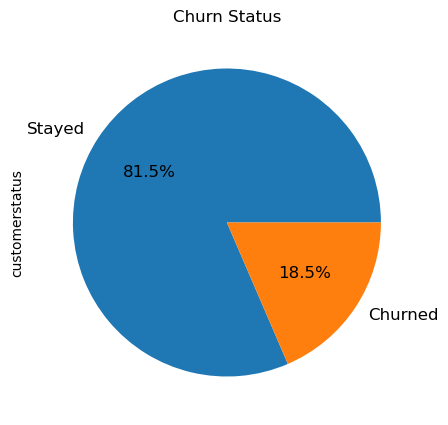

In [39]:
ax = (df['customerstatus'].value_counts()*100.0 /len(df))\
.plot.pie(autopct='%.1f%%', labels = ['Stayed', 'Churned'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Customers',fontsize = 12)
ax.set_title('Churn Status', fontsize = 12)

### Univariate Analysis
#### Plot distibution of individual predictors by Customer Status

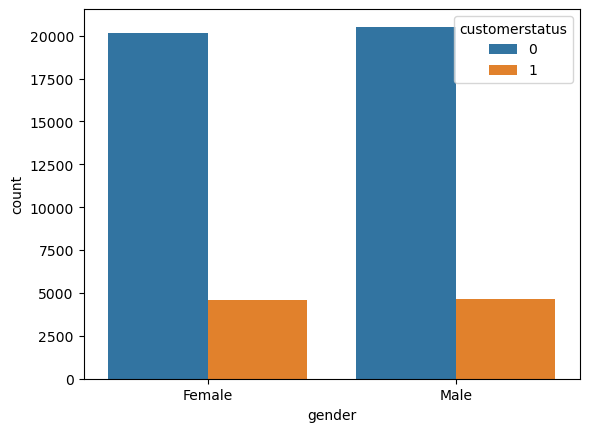

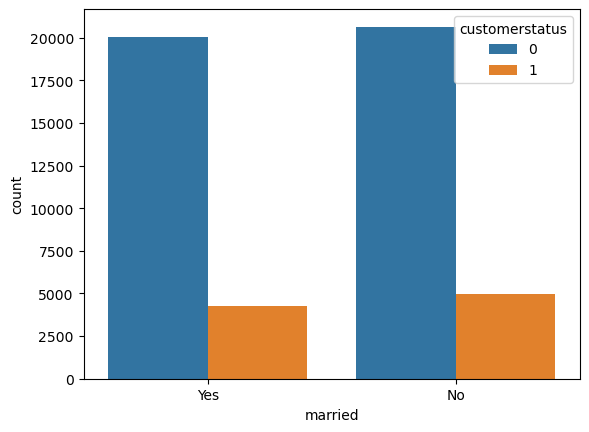

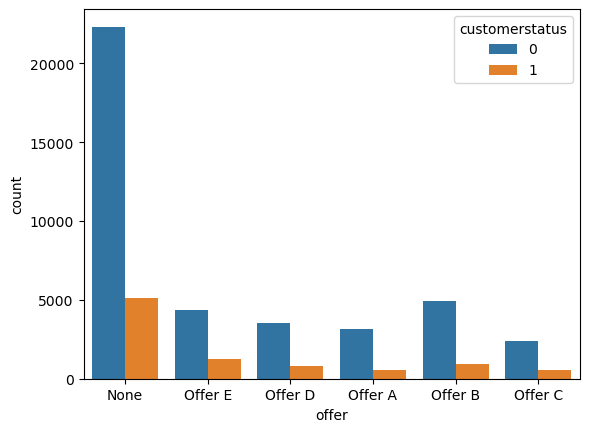

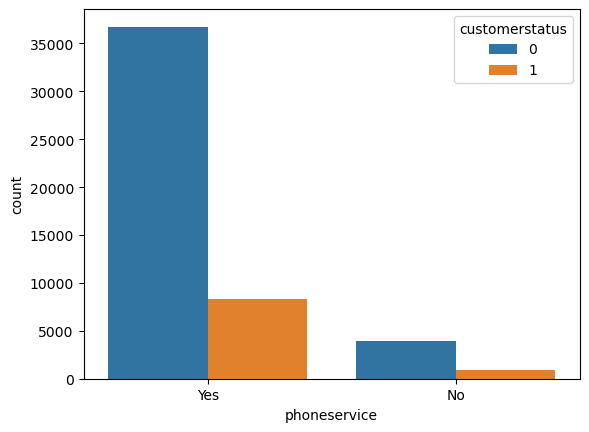

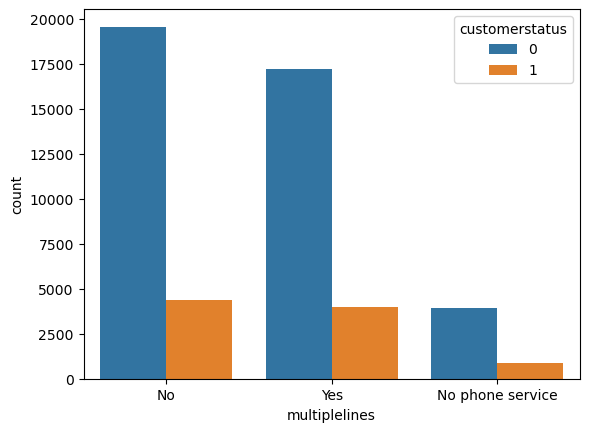

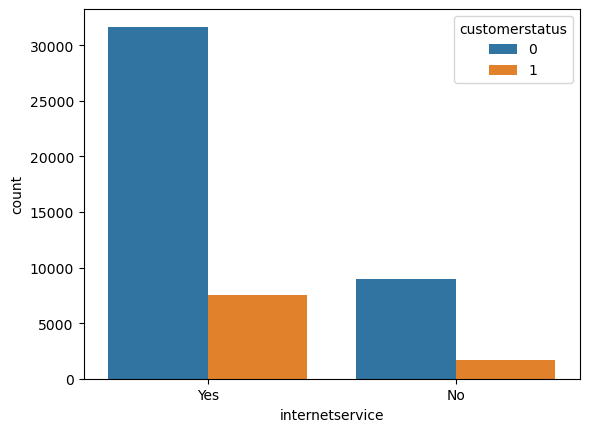

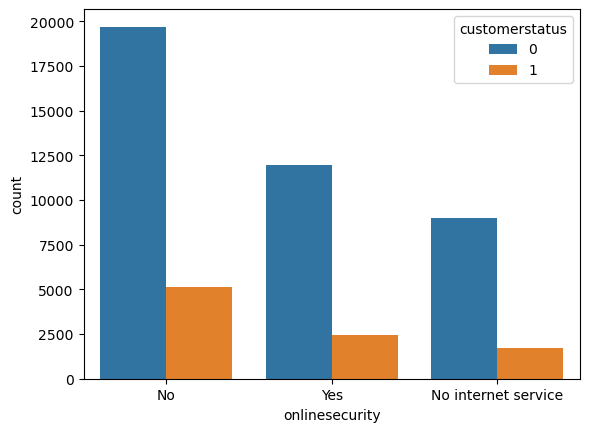

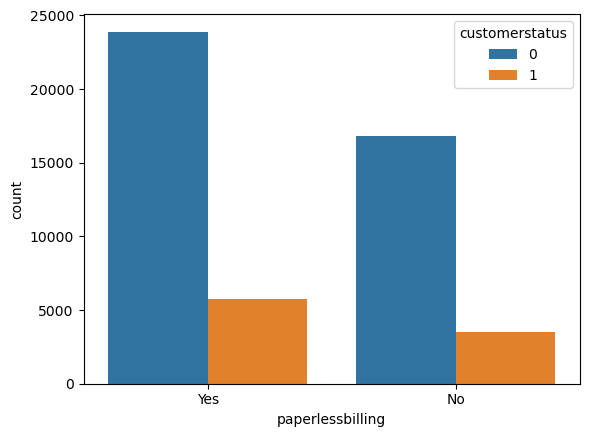

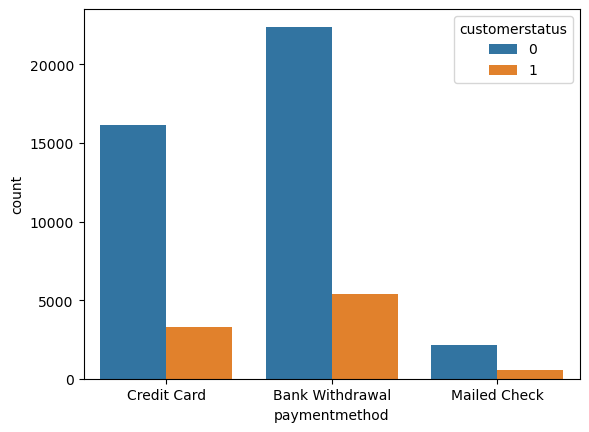

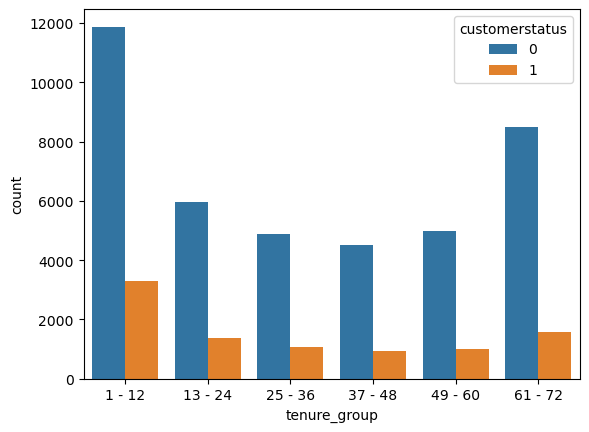

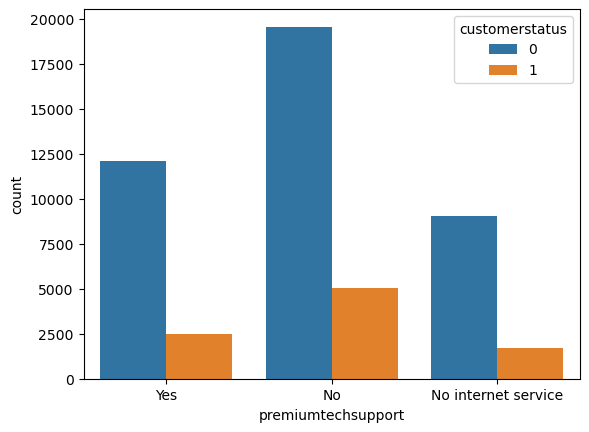

In [23]:
list1=['gender','married','offer','phoneservice','multiplelines','internetservice','onlinesecurity',
       'paperlessbilling', 'paymentmethod','tenure_group','premiumtechsupport']
for i, predictor in enumerate(list1):
    plt.figure(i)
    sns.countplot(data=df, x=predictor, hue='customerstatus')

In [24]:
fig = px.histogram(df, x="customerstatus", color = "contract", barmode = "group", title = "<b>Customer contract distribution<b>")
fig.update_layout(width=600, height=500, bargap=0.2)
fig.show()



1) By seeing the above histogram,it is seen that the customers who churned have significantly less number of one year and  two year of contract than stayed customers.

2) Customers those who have stayed have invested significantly more in two year contract than one year or month-to-month basis contract.

3) Also, from above chart it is clear that the customers who churned have high number of Month-to-Month contracts.

## Relationship between Monthly Charges and Total Charges


Text(0.5, 1.0, 'Relationship between Monthly Charges and Total Charges')

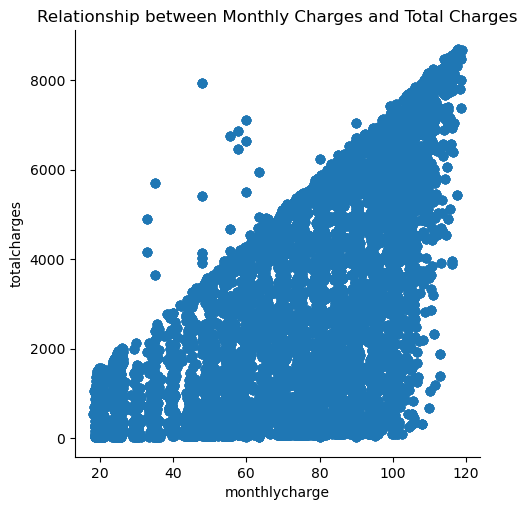

In [25]:
sns.lmplot(data=df, x='monthlycharge', y='totalcharges', fit_reg=False)
ax = plt.gca()
ax.set_title("Relationship between Monthly Charges and Total Charges")


 1) From above chart it is clear that Total Charges increase as Monthly Charges increases which is expected.
 
 2) From above chart it is clear that There are also negative charges for Monthly Charges as shown above 

### Due to more object columns we are transforming  the data through Label-Encoding for columns that are having just two unique values.

In [26]:
#Create a label encoder object
le = LabelEncoder()
# Label Encoding will be used for columns with 2 or less unique 

le_count = 0
for col in df.columns:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

5 columns were label encoded.


In [27]:
df.head()

gender  age  married  numberofdependents  numberofreferrals    offer  \
0       0   37        1                   0                  2     None   
1       1   46        0                   0                  0     None   
2       1   50        0                   0                  0  Offer E   
3       1   78        1                   0                  1  Offer D   
4       0   75        1                   0                  3     None   

   phoneservice  avgmonthlylongdistancecharges multiplelines  internetservice  \
0             1                          42.39            No                1   
1             1                          10.69           Yes                1   
2             1                          33.65            No                1   
3             1                          27.82            No                1   
4             1                           7.38            No                1   

   ...        contract  paperlessbilling    paymentmethod monthlycharge  \
0  ...        One Year                 1      Credit Card          65.6   
1  ...  Month-to-Month                 0      Credit Card          80.0   
2  ...  Month-to-Month                 1  Bank Withdrawal          73.9   
3  ...  Month-to-Month                 1  Bank Withdrawal          98.0   
4  ...  Month-to-Month                 1      Credit Card          83.9   

  totalcharges totalextradatacharges totallongdistancecharges totalrevenue  \
0       593.30                     0                   381.51       974.81   
1       542.40                    10                    96.21       610.28   
2       280.85                     0                   134.60       415.45   
3      1237.85                     0                   361.66      1599.51   
4       267.40                     0                    22.14       289.54   

  customerstatus tenure_group  
0              0       1 - 12  
1              0       1 - 12  
2              1       1 - 12  
3              1      13 - 24  
4              1       1 - 12  

[5 rows x 30 columns]

### Convert all the categorical variables into dummy variables (One-hot Encoding)

In [28]:
df_dummies = pd.get_dummies(df)
df_dummies.head()

gender  age  married  numberofdependents  numberofreferrals  phoneservice  \
0       0   37        1                   0                  2             1   
1       1   46        0                   0                  0             1   
2       1   50        0                   0                  0             1   
3       1   78        1                   0                  1             1   
4       0   75        1                   0                  3             1   

   avgmonthlylongdistancecharges  internetservice  avgmonthlygbdownload  \
0                          42.39                1                  16.0   
1                          10.69                1                  10.0   
2                          33.65                1                  30.0   
3                          27.82                1                   4.0   
4                           7.38                1                  11.0   

   paperlessbilling  ...  contract_Two Year  paymentmethod_Bank Withdrawal  \
0                 1  ...                  0                              0   
1                 0  ...                  0                              0   
2                 1  ...                  0                              1   
3                 1  ...                  0                              1   
4                 1  ...                  0                              0   

   paymentmethod_Credit Card  paymentmethod_Mailed Check  tenure_group_1 - 12  \
0                          1                           0                    1   
1                          1                           0                    1   
2                          0                           0                    1   
3                          0                           0                    0   
4                          1                           0                    1   

   tenure_group_13 - 24  tenure_group_25 - 36  tenure_group_37 - 48  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     1                     0                     0   
4                     0                     0                     0   

   tenure_group_49 - 60  tenure_group_61 - 72  
0                     0                     0  
1                     0                     0  
2                     0                     0  
3                     0                     0  
4                     0                     0  

[5 rows x 65 columns]

<AxesSubplot:>

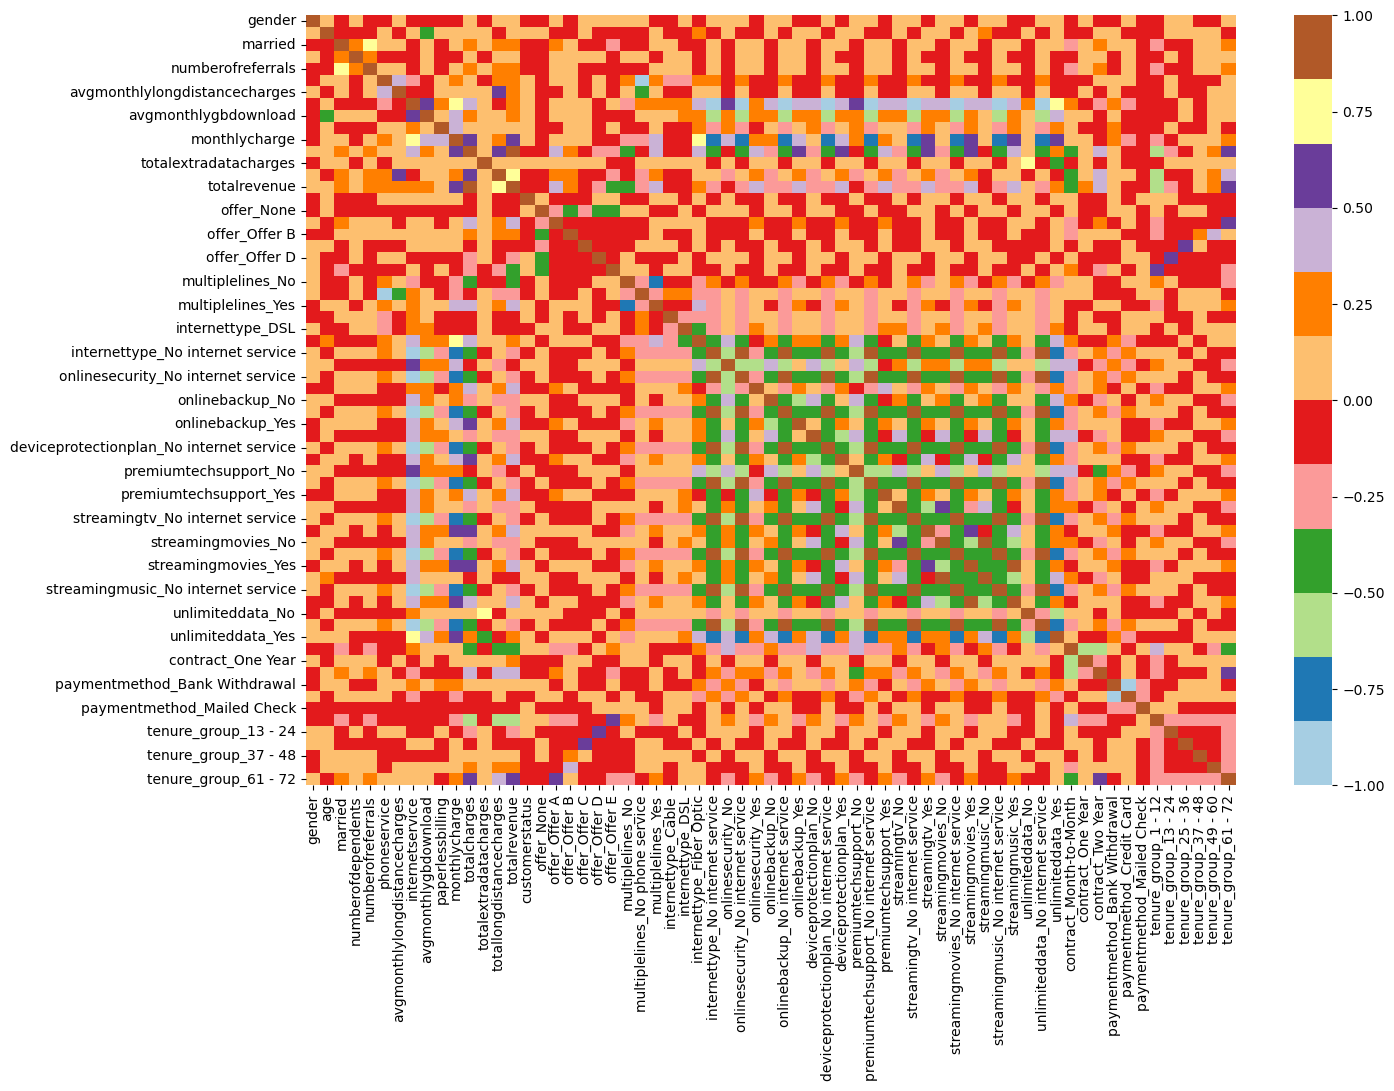

In [29]:
plt.figure(figsize=(15,10))
sns.heatmap(df_dummies.corr(), cmap = 'Paired')


In [30]:
ll = ['gender', 'married', 'phoneservice','internetservice','paperlessbilling','internettype_Cable', 'internettype_DSL',
       'internettype_Fiber Optic','contract_Month-to-Month', 'contract_One Year','contract_Two Year', 'paymentmethod_Bank Withdrawal',
       'paymentmethod_Credit Card', 'paymentmethod_Mailed Check']

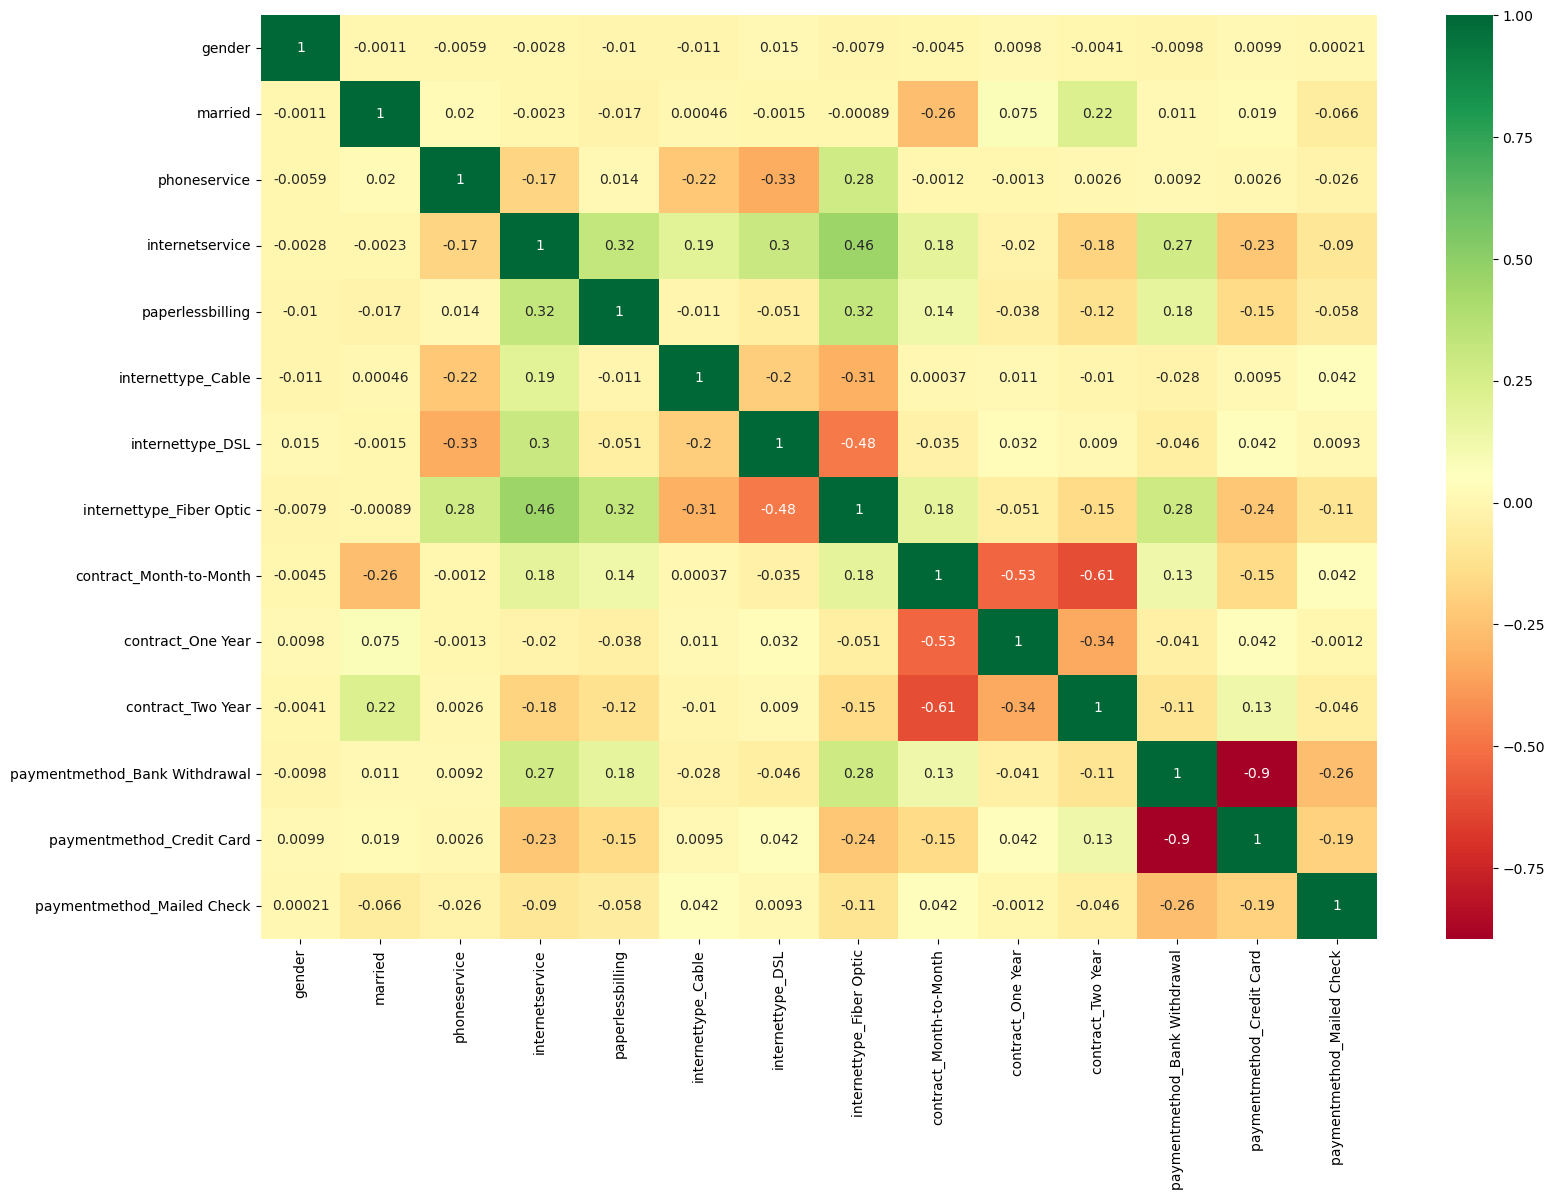

In [31]:
#Customers Who stayed
plt.figure(figsize = [18,12])
sns.heatmap(df_dummies.loc[df_dummies.customerstatus == 0, ll].corr(), cmap = 'RdYlGn', annot = True)
plt.show()

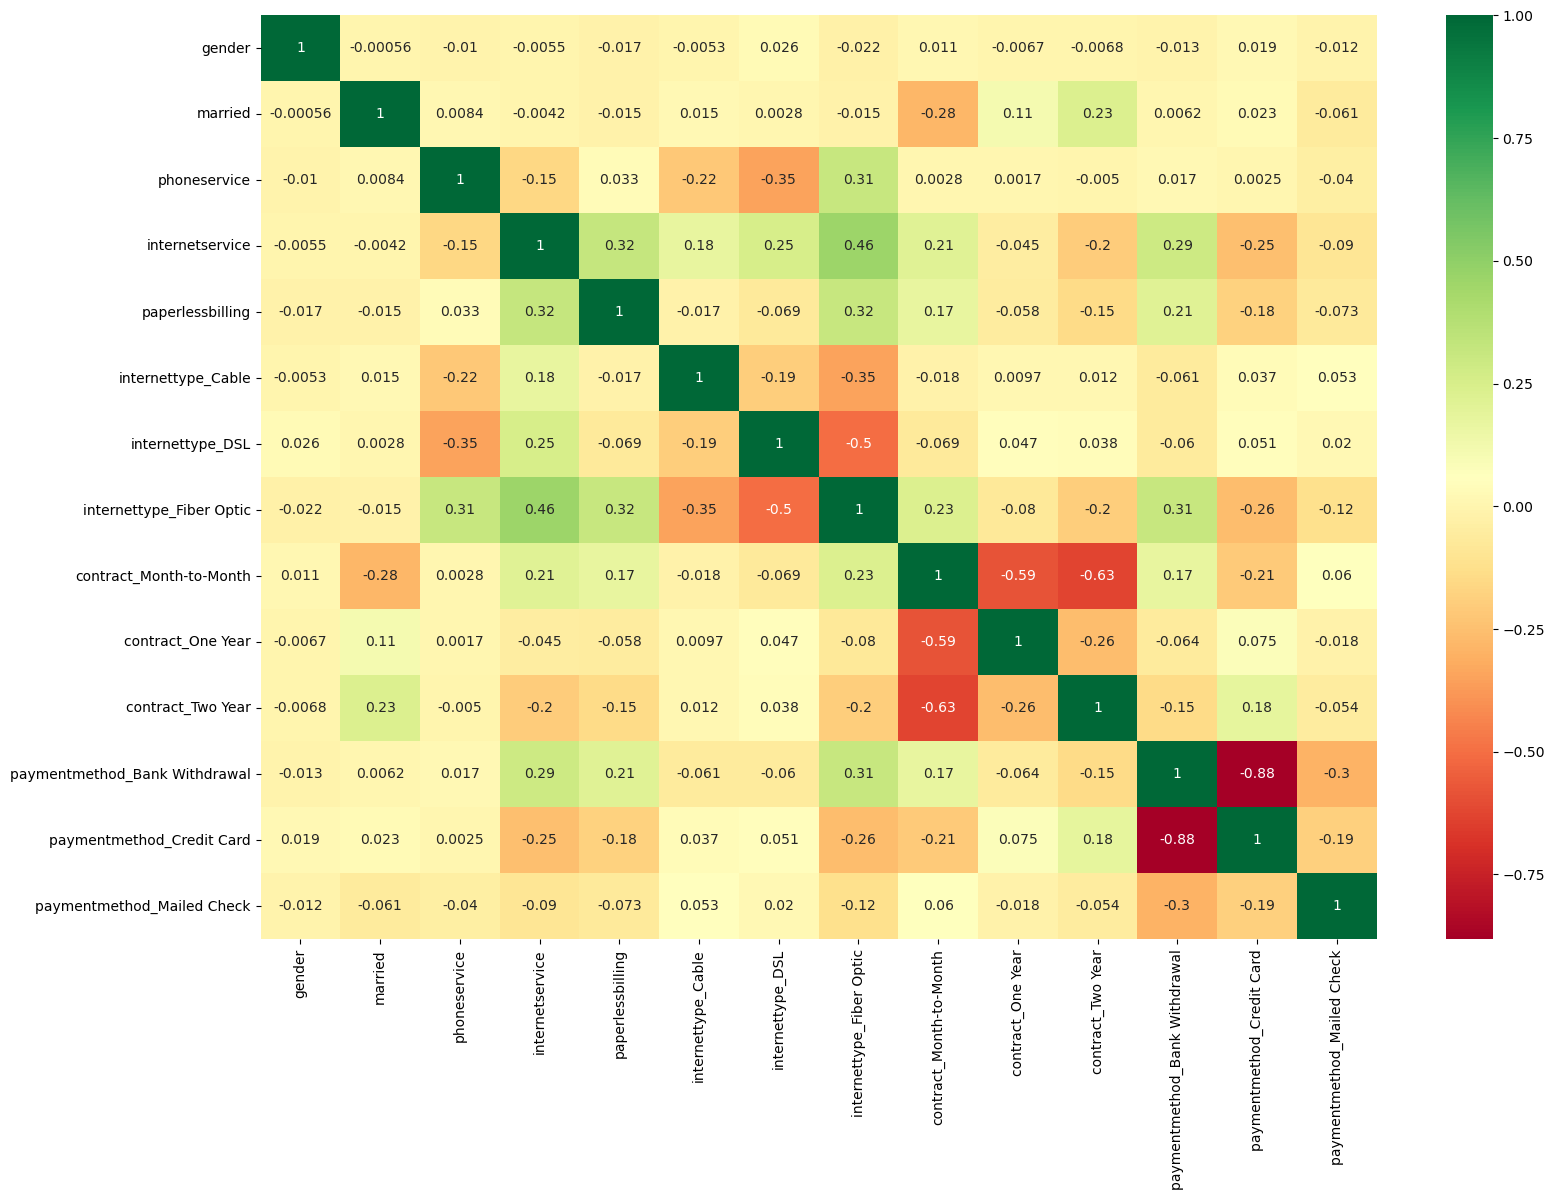

In [32]:
#customers who churned
plt.figure(figsize = [18,12])
sns.heatmap(df_dummies.loc[df_dummies.customerstatus == 1, ll].corr(), cmap = 'RdYlGn', annot = True)
plt.show()

**HIGH** Churn seen in case of  **Month to month contracts**, **No online security**, **No Tech support**, **First year of subscription** and **Fibre Optics Internet**

**LOW** Churn is seens in case of **Long term contracts**, **Subscriptions without internet service** and **The customers engaged for 5+ years**

Factors like **Gender**, **Availability of PhoneService** and  **of multiple lines** have almost **NO** impact on Churn

# Conclusion

### These are some of the quick insights from above EDA:

- Bank Withdrawal medium are the highest churners
- Contract Type - Monthly customers are more likely to churn because of no contract terms, as they are free to go customers.
- No Online security, No Tech Support category are high churners


### Saving altered Data to csv

In [33]:
df_dummies.to_csv('Telecomm-churn-retention-data-result.csv')
